In [28]:
from google.colab import drive #ignorar si no se ejecuta en Colab
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [29]:
!pip install --upgrade jax jaxlib netket optax

  Using cached jax-0.6.2-py3-none-any.whl.metadata (13 kB)
  Using cached jaxlib-0.6.2-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.3 kB)
  Using cached ml_dtypes-0.5.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (21 kB)


In [30]:
import os
import sys
import argparse
from typing import Sequence, Tuple, List
import time

import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt


import jax
import jax.numpy as jnp
import jaxlib
import flax
import flax.linen as nn
import optax


import netket as nk
import netket.experimental as nkx
from netket.sampler import MetropolisRule
from netket.utils.struct import dataclass
from netket.operator.spin import sigmax, sigmaz

In [31]:
sys.path.insert(0,'/content/gdrive/MyDrive/Colab Notebooks/TFG/transformer_LR_WF/GitHub_prep/')

In [32]:
from utils import circulant, BestIterKeeper,InvertMagnetization
from hamiltonian import get_Hamiltonian,get_eigvals
from funciones_auxiliares import *
from mpgnn_ansatz import *
from Function_GNN import *

ModuleNotFoundError: No module named 'funciones_auxiliares'

In [ ]:
print(jax.__version__)
print(jaxlib.__version__)
print(nk.__version__)
print(optax.__version__)
print(np.__version__)
print(flax.__version__)

0.5.3
0.5.3
3.18
0.2.5
2.0.2
0.10.6


In [ ]:
def make_extract_metrics(metrics_history):
  '''
  Función que extrae metricas durante la optimización.
  '''
  def extract_metrics(step, log_data, driver):
      stats = driver.state.expect(H)
      energy = float(jnp.real(stats.mean))
      energy_error = float(jnp.real(stats.error_of_mean))

      loss = float(jnp.real(getattr(log_data[driver._loss_name], "mean")))
      variance = float(jnp.real(getattr(log_data[driver._loss_name], "variance")))

      metrics_history['step'].append(step)
      metrics_history['energy'].append(energy)
      metrics_history['energy_error'].append(energy_error)
      metrics_history['loss'].append(loss)
      metrics_history['variance'].append(variance)

      print(f"Step {step}: Energy = {energy:.6f} ± {energy_error:.2e}, Loss = {loss:.4f}, Variance = {variance:.4f}")
      return True

  return extract_metrics


In [ ]:


diagonalize = True
trivial = False
N = 20
alpha = 0.0 #3, 6
J = 1.0
b = 1
h=-1
num_message_pass = [2, 3, 4]

In [ ]:
# Creación del espacio de Hilbert y otros observables

hi = nk.hilbert.Spin(s=1 / 2, N=N)

#definimos métricas adicionales
renyi = nkx.observable.Renyi2EntanglementEntropy(
    hi, np.arange(0, N / 2 + 1, dtype=int)
)

mags = sum([(-1) ** i * sigmaz(hi, i) / N for i in range(N)])

magnet = sum([sigmaz(hi, i) / N for i in range(N)])


In [ ]:
# MC reglas de muestreo
rule1 = nk.sampler.rules.LocalRule() #flip de un solo spin para proponer nuevo estado
pflip = 1
sampler = nk.sampler.MetropolisSampler(
    hi, nk.sampler.rules.MultipleRules([rule1], [pflip])
)


In [ ]:
# Protocolo de entrenamiento
max_iters = 300
ramp_iter = 50
lrmax = 0.05


lr_schedule = optax.warmup_exponential_decay_schedule(
    init_value=1e-4,
    peak_value=0.05,
    warmup_steps=30,
    transition_steps=100,
    decay_rate=0.97
)


optimizer = nk.optimizer.Sgd(learning_rate = lr_schedule)

ds_schedule = optax.linear_schedule(1e-3, 1e-5, max_iters)
SR = nk.optimizer.SR(diag_shift=ds_schedule)


In [ ]:
order = 200

# Hamiltoniano
H ,N_norm  = get_Hamiltonian(N=N, J=J, alpha=alpha, return_norm=True)

with jax.default_device(jax.devices("cpu")[0]):
    Egs, eigenvec = get_eigvals(Hamiltonian=H, order=order, eigenvecs=True)




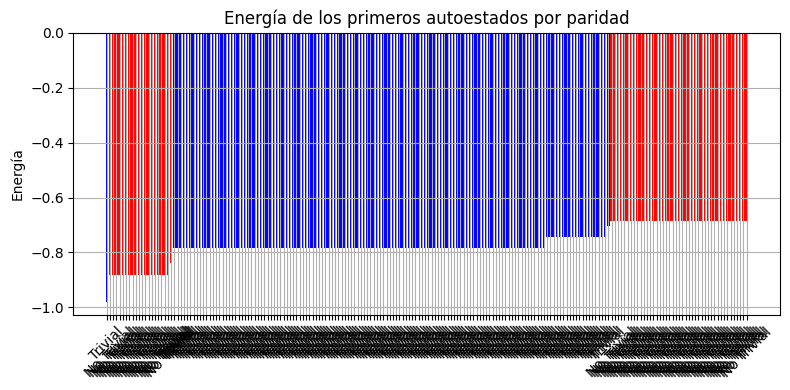

In [ ]:
soluciones = []
energias = []

for i in range(eigenvec.shape[1]):
    v = eigenvec[:, i]
    is_odd = jnp.allclose(v + v[::-1], 0.0, atol=1e-3)
    soluciones.append('No Trivial' if is_odd else 'Trivial')
    energias.append(Egs[i])

# visualizamos las irreps
plt.figure(figsize=(8, 4))
colors = ['red' if p == 'No Trivial' else 'blue' for p in soluciones]
plt.bar(range(len(energias)), energias, color=colors)
plt.xticks(range(len(energias)), soluciones, rotation=45)
plt.ylabel("Energía")
plt.title("Energía de los primeros autoestados por paridad")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
vecinos_hashable, exchange_coefficients_tuple = obtener_vecinos_y_coeficientes(N, N_norm, b, alpha, J)

In [ ]:
#definimos el modelo
modelos = []
for i in num_message_pass:

  model = sym_MPGNN(
      trivial=trivial,
      N=N,
      num_message_pass = i,
      vecinos=vecinos_hashable,
      exchange_coefficients =exchange_coefficients_tuple,
  )

  model_name = model.__class__.__name__
  modelos.append(model)



NameError: name 'sym_MPGNN' is not defined

In [ ]:
import time

seed = int(time.time()) #creamos seed pseudoaleatoria para inicializar estado

In [ ]:
# Inicialización de estado de Montecarlo
vstate_list = []
gs_list = []
keeper_list = []
log_list = []


for i, model in enumerate(modelos):

  vstate = nk.vqs.MCState(
      sampler,
      model,
      n_samples=512,
      n_discard_per_chain=0,
      chunk_size=64,
      seed = seed
  )

  gs = nk.driver.VMC(
      H,
      optimizer,
      variational_state=vstate,
      preconditioner=SR,## stochastic reconfiguration
  )

  keeper = BestIterKeeper(H, N, 1e-8)
  log = nk.logging.RuntimeLog()

  #guardamos todas las inicializaciones, drivers y keepers uno por paso de mensaje
  vstate_list.append(vstate)
  gs_list.append(gs)
  keeper_list.append(keeper)
  log_list.append(log)


/usr/local/lib/python3.11/dist-packages/jax/_src/ops/scatter.py:93: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


In [ ]:
for i in vstate_list:
  n_params = sum(x.size for x in jax.tree_util.tree_leaves(i.parameters))
  print("Número total de parámetros:", n_params)

Número total de parámetros: 508
Número total de parámetros: 722
Número total de parámetros: 936


In [ ]:
#guardamos la primera energía, como se inicializa
vstate_init =  []
for vstate in vstate_list:
  vstate_init.append(vstate.expect(H))

/usr/local/lib/python3.11/dist-packages/jax/_src/ops/scatter.py:93: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/jax/_src/ops/scatter.py:93: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/jax/_src/ops/scatter.py:93: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


In [ ]:
file_path = "/content/gdrive/MyDrive/Colab Notebooks/TFG/transformer_LR_WF/first_energies.txt" # Ajustar el directorio
with  open(file_path, 'w') as f:
    for vstate in vstate_init:
        print(vstate, file=f)
    print("ground_energy=" ,Egs[0] , file=f)

In [ ]:
metrics_history = [{'step': [], 'energy': [], 'energy_error': [], 'loss': [], 'variance': []} for _ in range(len(num_message_pass))]

In [ ]:
# Running the VMC optimization
for i, gs in enumerate(gs_list):
    # Crea el callback específico para el i-ésimo modelo
    callback_fn = [keeper_list[i].update, make_extract_metrics(metrics_history[i])]

    gs.run(n_iter=max_iters, out = log_list[i], callback=callback_fn, show_progress=True)

  0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/jax/_src/ops/scatter.py:93: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


Step 0: Energy = -0.818716 ± 2.73e-03, Loss = -0.8187, Variance = 0.0038
Step 1: Energy = -0.823555 ± 2.64e-03, Loss = -0.8236, Variance = 0.0036
Step 2: Energy = -0.825391 ± 2.69e-03, Loss = -0.8254, Variance = 0.0037
Step 3: Energy = -0.823204 ± 2.77e-03, Loss = -0.8232, Variance = 0.0039
Step 4: Energy = -0.822407 ± 2.69e-03, Loss = -0.8224, Variance = 0.0037
Step 5: Energy = -0.827571 ± 2.70e-03, Loss = -0.8276, Variance = 0.0037
Step 6: Energy = -0.824498 ± 2.78e-03, Loss = -0.8245, Variance = 0.0040
Step 7: Energy = -0.821974 ± 2.90e-03, Loss = -0.8220, Variance = 0.0043
Step 8: Energy = -0.830381 ± 2.43e-03, Loss = -0.8304, Variance = 0.0030
Step 9: Energy = -0.831162 ± 2.57e-03, Loss = -0.8312, Variance = 0.0034
Step 10: Energy = -0.827812 ± 2.64e-03, Loss = -0.8278, Variance = 0.0036
Step 11: Energy = -0.825908 ± 2.62e-03, Loss = -0.8259, Variance = 0.0035
Step 12: Energy = -0.825380 ± 2.60e-03, Loss = -0.8254, Variance = 0.0035
Step 13: Energy = -0.824201 ± 2.65e-03, Loss = -

  0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/jax/_src/ops/scatter.py:93: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


Step 0: Energy = -0.818124 ± 2.80e-03, Loss = -0.8181, Variance = 0.0040
Step 1: Energy = -0.825901 ± 2.58e-03, Loss = -0.8259, Variance = 0.0034
Step 2: Energy = -0.825213 ± 2.75e-03, Loss = -0.8252, Variance = 0.0039
Step 3: Energy = -0.822126 ± 2.86e-03, Loss = -0.8221, Variance = 0.0042
Step 4: Energy = -0.821339 ± 2.73e-03, Loss = -0.8213, Variance = 0.0038
Step 5: Energy = -0.826483 ± 2.77e-03, Loss = -0.8265, Variance = 0.0039
Step 6: Energy = -0.823864 ± 2.87e-03, Loss = -0.8239, Variance = 0.0042
Step 7: Energy = -0.823772 ± 2.86e-03, Loss = -0.8238, Variance = 0.0042
Step 8: Energy = -0.828013 ± 2.44e-03, Loss = -0.8280, Variance = 0.0030
Step 9: Energy = -0.831549 ± 2.48e-03, Loss = -0.8315, Variance = 0.0031
Step 10: Energy = -0.823690 ± 2.79e-03, Loss = -0.8237, Variance = 0.0040
Step 11: Energy = -0.826857 ± 2.50e-03, Loss = -0.8269, Variance = 0.0032
Step 12: Energy = -0.824351 ± 2.66e-03, Loss = -0.8244, Variance = 0.0036
Step 13: Energy = -0.823588 ± 2.61e-03, Loss = -

  0%|          | 0/300 [00:00<?, ?it/s]

Step 0: Energy = -0.819819 ± 2.75e-03, Loss = -0.8198, Variance = 0.0039
Step 1: Energy = -0.824743 ± 2.63e-03, Loss = -0.8247, Variance = 0.0036
Step 2: Energy = -0.822504 ± 3.05e-03, Loss = -0.8225, Variance = 0.0048
Step 3: Energy = -0.820137 ± 2.78e-03, Loss = -0.8201, Variance = 0.0039
Step 4: Energy = -0.817269 ± 2.97e-03, Loss = -0.8173, Variance = 0.0045
Step 5: Energy = -0.824135 ± 2.94e-03, Loss = -0.8241, Variance = 0.0044
Step 6: Energy = -0.825461 ± 2.83e-03, Loss = -0.8255, Variance = 0.0041
Step 7: Energy = -0.822731 ± 2.91e-03, Loss = -0.8227, Variance = 0.0043
Step 8: Energy = -0.829645 ± 2.34e-03, Loss = -0.8296, Variance = 0.0028
Step 9: Energy = -0.828228 ± 2.66e-03, Loss = -0.8282, Variance = 0.0036
Step 10: Energy = -0.825977 ± 2.73e-03, Loss = -0.8260, Variance = 0.0038
Step 11: Energy = -0.825909 ± 2.83e-03, Loss = -0.8259, Variance = 0.0041
Step 12: Energy = -0.826992 ± 2.58e-03, Loss = -0.8270, Variance = 0.0034
Step 13: Energy = -0.826914 ± 2.60e-03, Loss = -

In [ ]:
metrics_history = np.array(metrics_history)

(3,)

In [ ]:
file_path = "/content/gdrive/MyDrive/Colab Notebooks/TFG/transformer_LR_WF/metrics_data.txt" # Ajustar el directorio

with open(file_path, 'w') as f:
    np.savetxt(f, metrics_history.T, fmt='%s', delimiter='\t')
    print(f"Metrics data saved to: {file_path}")

Metrics data saved to: /content/gdrive/MyDrive/Colab Notebooks/TFG/transformer_LR_WF/metrics_data.txt


In [ ]:
energia_min_array = []
for i in range(len(num_message_pass)):
  energia_min_array.append(keeper_list[i].best_energy)

In [ ]:
file_path = "/content/gdrive/MyDrive/Colab Notebooks/TFG/transformer_LR_WF/evaluation_results.txt" # Ajustar el directorio
with open(file_path, 'w') as f:
    for keeper in keeper_list:
        if diagonalize:
            fidelity = np.abs(keeper.best_state.to_array().conj() @ eigenvec[:, 0])
            rel_err = np.abs((keeper.best_energy - Egs[0]) / Egs[0])
            print(f"Fidelity1: {fidelity:.5f}", file=f)
            print(f"Relative error in energy: {rel_err:.2E}", file=f)
        vsc = keeper.vscore
        print(f"V-score: {vsc:.2E}", file=f)
        S = np.real(keeper.best_state.expect(renyi).mean)
        print(f"Value for the Renyi-2 entropy: {S:.5f}", file=f)
        m = np.real(keeper.best_state.expect(magnet).mean)
        print(f"Value for the magnetization: {m:.5f}", file=f)
        ms = np.real(keeper.best_state.expect(mags).mean)
        print(f"Value for the staggered magnetization: {ms:.5f}", file=f)
        fluct = np.real(keeper.best_state.expect(magnet @ magnet).mean)
        print(f"Value for the squared magnetization: {fluct:.5f}", file=f)
        fluct_s = np.real(keeper.best_state.expect(mags @ mags).mean)
        print(f"Value for the squared staggered magnetization: {fluct_s:.5f}", file=f)
    print(f"Evaluation results saved to: {file_path}")

Evaluation results saved to: /content/gdrive/MyDrive/Colab Notebooks/TFG/transformer_LR_WF/evaluation_results.txt


In [ ]:
file_path = '/content/gdrive/MyDrive/Colab Notebooks/TFG/transformer_LR_WF/support.txt' # Ajustar el directorio
rows = []

j = 2
for keeper in keeper_list:
    for i in range(order):
        fidelity = np.abs(keeper.best_state.to_array().conj() @ eigenvec[:, i])
        rel_err = np.abs((keeper.best_energy - Egs[i]) / Egs[i])
        vsc = keeper.vscore

        rows.append({
            'MP': j,
            'Solución': soluciones[i],
            'Energía': Egs[i],
            'Fidelidad': fidelity,
            'Error relativo': rel_err,
            'V-score': vsc
        })
    j += 1

#crear DataFrame
df = pd.DataFrame(rows)

with open(file_path, 'w') as f:
    f.write(df.to_string(index=False))


In [ ]:
file_path = '/content/gdrive/MyDrive/Colab Notebooks/TFG/transformer_LR_WF/support.csv' # Ajustar el directorio
rows = []

j = 2
for keeper in keeper_list:
    for i in range(order):
        fidelity = np.abs(keeper.best_state.to_array().conj() @ eigenvec[:, i])
        rel_err = np.abs((keeper.best_energy - Egs[i]) / Egs[i])
        vsc = keeper.vscore

        rows.append({
            'MP': j,
            'Solución': soluciones[i],
            'Energía': Egs[i],
            'Fidelidad': fidelity,
            'Error relativo': rel_err,
            'V-score': vsc
        })
    j += 1

df = pd.DataFrame(rows)

df.to_csv(file_path, index=False)
